# BioConvert 
## Materials for manuscripts


This notebook generates images used in the manuscript (https://www.biorxiv.org/content/10.1101/2023.03.13.532455v2) . Images were created with version 0.6.3 installed locally or on a cluster using this methodoloy:

    conda create --name bioconvert python=3.8
    conda install mamba
    mamba install bioconvert -c bioconda
    # v0.6.3 was used (equivalent to 1.0.0), installed a tag version
    git clone https://github.com/bioconvert/bioconvert --branch v0.6.3
    cd bioconvert
    pip install .

In [1]:
from bioconvert.core.registry import Registry
import os
import subprocess
from pylab import *

from IPython.display import Image
rcParams['figure.figsize'] = (10,7)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 12

In [5]:
OUTDIR = "images2"
os.makedirs(OUTDIR, exist_ok=True)

# Histogram number of methods per conversion

WARNING [bioconvert.core.base:147]:  converter 'SRA2FASTQ': method fastq_dump is not available


Number of formats: 49
Number of converters: 100
Number of methods : 154


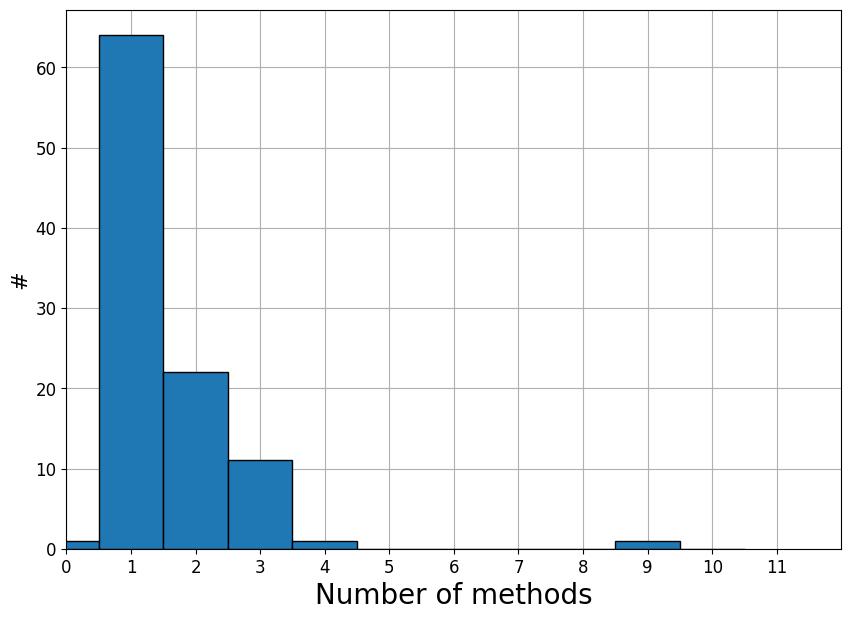

In [6]:
r = Registry()
info = r.get_info()

# The available unique converters
converters = [x for x in info.items()]

# the number of methods per converter
data = [info[k] for k, v in info.items()]

# the number of formats
A1 = [y for x in list(r.get_conversions()) for y in x[0]]
A2 = [y for x in list(r.get_conversions()) for y in x[1]]
formats = set(A1 + A2)

print("Number of formats: {}".format(len(formats)))
print("Number of converters: {}".format(len(converters)))
print("Number of methods : {}".format(sum(data)))

hist(data, range(12), ec="k", zorder=2, align="left")
xlim([0,12])
xticks(range(12), range(12))
xlabel("Number of methods", fontsize=20)
ylabel("#", fontsize=16)
grid(zorder=-1)

for ext in ['png', 'svg', 'eps', 'pdf']:
    savefig(f"{OUTDIR}/hist_data.{ext}", dpi=200)

# Graph clustered

In [7]:
from bioconvert.core.graph import create_graph


In [9]:
_ = create_graph(f"{OUTDIR}/graph_clustered_conversion.png", use_singularity=False, include_subgraph=True)

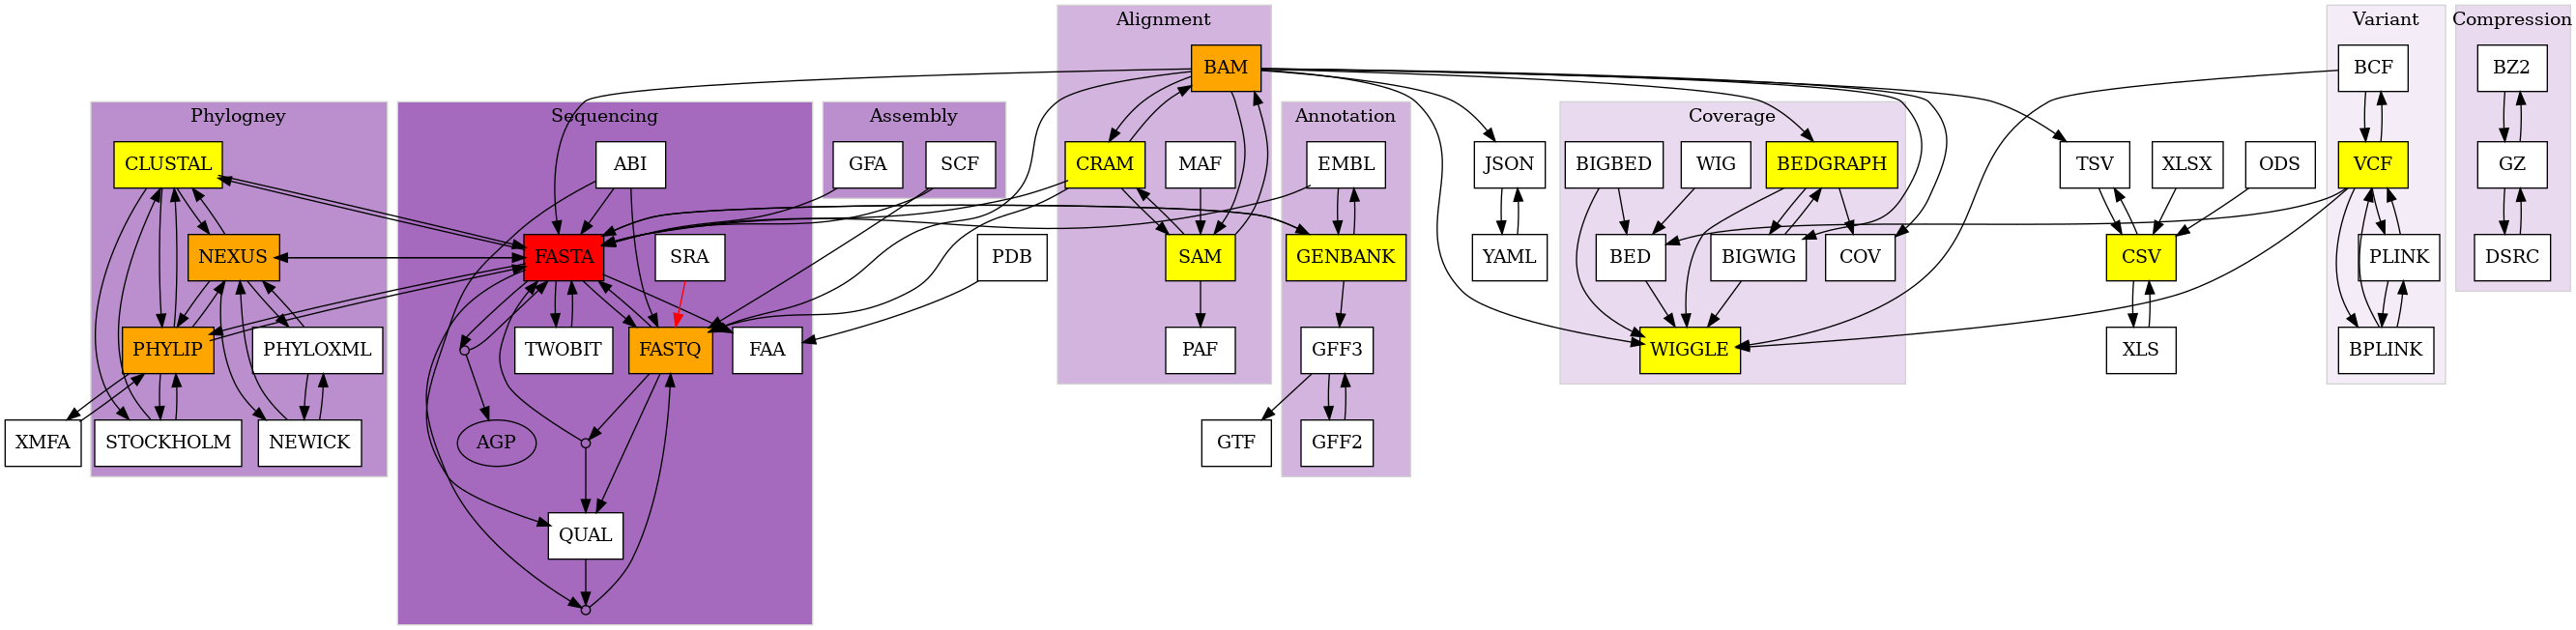

In [10]:
Image(filename=f"{OUTDIR}/graph_clustered_conversion.png")

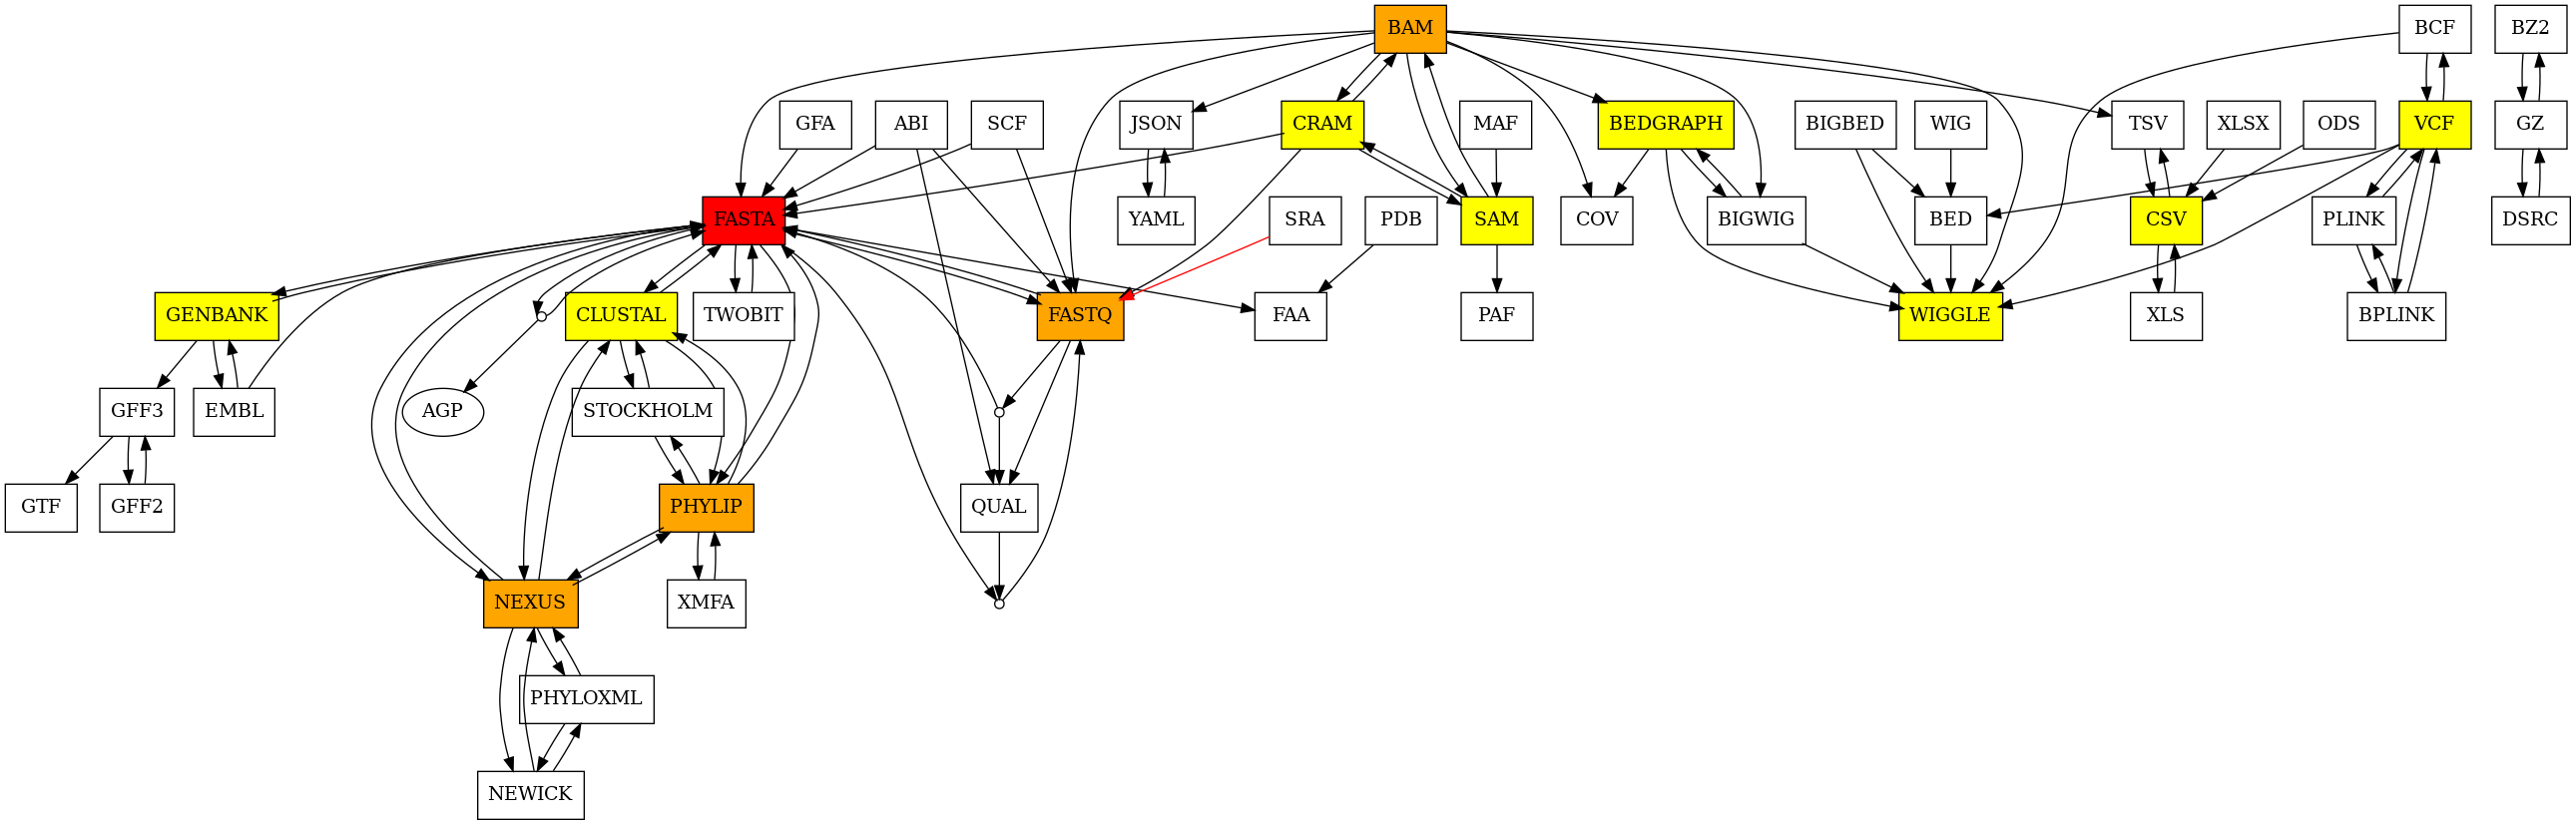

In [12]:
_ = create_graph(f"{OUTDIR}/graph_conversion.png", use_singularity=False)
Image(filename=f"{OUTDIR}/graph_conversion.png")

# Benchmarking


# Benchmarking FastQ2Fasta (simulated data)
## Input/Output data are not compressed in this example

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


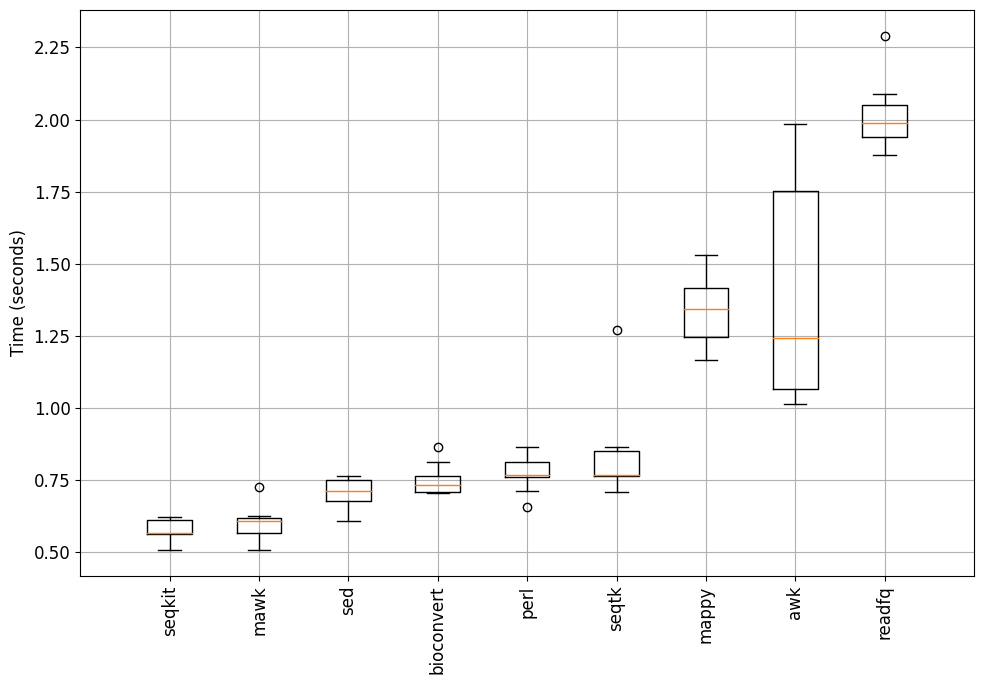

In [14]:
# Generate the dummy data, saving the results in a temporary file
from easydev import TempFile
from bioconvert.simulator.fastq import FastqSim
from bioconvert.fastq2fasta import FASTQ2FASTA

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

# Perform the benchmarking
c = FASTQ2FASTA(infile.name, outfile.name)
data = c.compute_benchmark(N=10)
data = c.boxplot_benchmark()

infile.delete()
outfile.delete()
savefig(f"{OUTDIR}/benchmark_fastq2fasta_uncompressed_1000000.png", dpi=200)
savefig(f"{OUTDIR}/benchmark_fastq2fasta_uncompressed_1000000.pdf", dpi=200)

## Same benchmark as above with compresssed input fastq file  (Figure 4)

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]


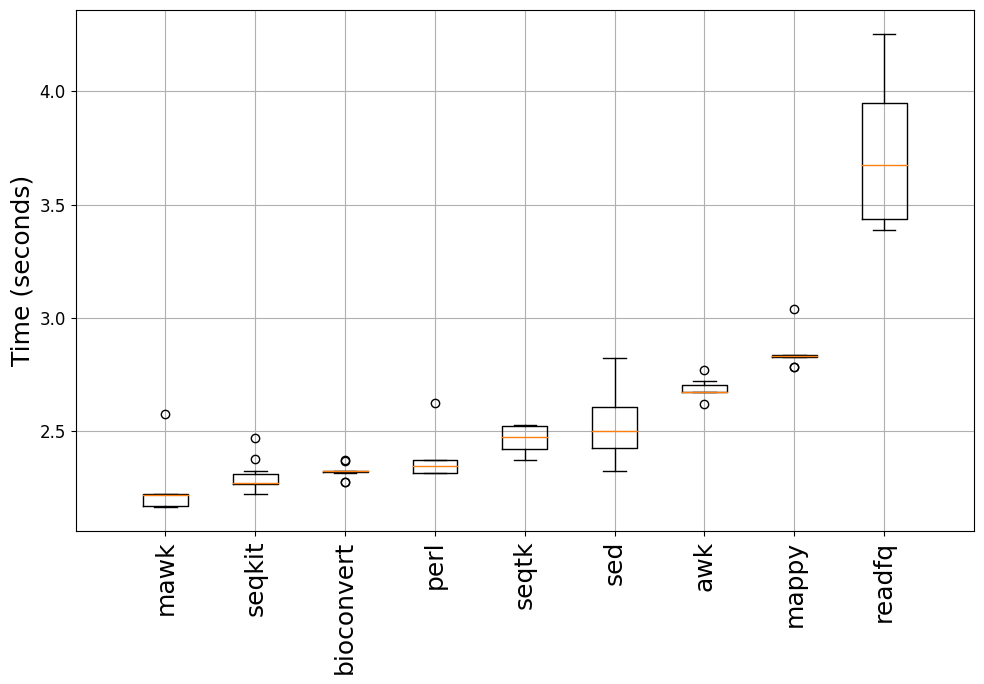

In [21]:

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

cmd = f"pigz {infile.name}"
import subprocess
subprocess.run(cmd.split())
# Perform the benchmarking
c = FASTQ2FASTA(infile.name + ".gz", outfile.name)
c.compute_benchmark(N=10)
c.boxplot_benchmark()

# here, just to tweak the fontsize of labels and ticks for the paper.
data = c._benchmark.results


methods = sorted(data["time"], key=lambda x: mean(data["time"][x]))
xticks(*zip(*enumerate(methods, start=1)), rotation=90, fontsize=18)
ylabel('Time (seconds)', fontsize=18)
# cleanup
cmd = f"unpigz {infile.name}"
subprocess.run(cmd.split())

infile.delete()
outfile.delete()
tight_layout()
savefig(f"{OUTDIR}/benchmark_in_compression.png", dpi=200)
savefig(f"{OUTDIR}/benchmark_in_compression.pdf", dpi=200)


# Multi benchmark

The multi benchmark requires input data files. They can be downloaded from Zenodo for the BAM file.
The multibenchmark of the fastq2fasta conversion

First, we can download some test data that are posted on Zenodo

In [55]:
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam -O inputs/test.bam
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam.bai -O inputs/test.bam.bai


--2022-10-17 11:26:14--  https://zenodo.org/record/6405971/files/measles.sorted.bam
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68393900 (65M) [application/octet-stream]
Saving to: ‘inputs/test.bam’

inputs/test.bam     100%[===================>]  65.22M  6.45MB/s    in 14s     

2022-10-17 11:26:29 (4.62 MB/s) - ‘inputs/test.bam’ saved [68393900/68393900]

--2022-10-17 11:26:29--  https://zenodo.org/record/6405971/files/measles.sorted.bam.bai
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96 [application/octet-stream]
Saving to: ‘inputs/test.bam.bai’

inputs/test.bam.bai 100%[===================>]      96  --.-KB/s    in 0s      

2022-10-17 11:26:30 (7.98 MB/s) - ‘inputs/test.bam.bai’ saved [96/96]



Then, we run the same benchmark as before using the bioconvert command;
However, we will launch it several times (benchmark_num=5) and gather results as josn files into ./json

# Generate the benchmark data

Users must generate the benchmark results using the following script (adapted to your needs)
We also have a Snakemake file called Snakefile_benchmark to parallelised the process.
Otherwise, simply run the bioconvert command N times as follows


In [32]:
from tqdm import tqdm
benchmark_num = 5
for i in tqdm(range(benchmark_num), position=1):
    cmd = f"bioconvert bam2sam -b -N 10 -T json/test_bam2sam_{i} inputs/test.bam outputs/test.sam -f "
    subprocess.run(cmd.split(), stderr=subprocess.PIPE)


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [09:09<00:00, 109.83s/it]


## Utility function to gather json results

In [22]:


def concatenate_json(pattern="json/test_bam2sam_*.json", output="json/test_bam2sam.json"):
    import pandas as pd

    import glob
    files = sorted(glob.glob(pattern))
    
    with open(files[0]) as fin:
        dd = fin.read()
        df = pd.read_json(dd["time"])

    # Creation of another column containing the benchmarking number
    df = df.assign(Benchmark=1)
 
    for i in range(1, int(benchmark_num)):
        # open and read JSON file
        with open(files[i]) as fin:
            dd = fin.read()
            df_temp = pd.read_json(dd["time"])        

        # Creation of another column containing the benchmarking number
        df_temp = df_temp.assign(Benchmark=i + 1)
 
        # Concatenation of the two JSON objects
        df = pd.concat([df, df_temp], axis=0)
        # The index is reset to avoid problems when exporting the final JSON file
    df.reset_index(inplace=True, drop=True)
    # Creation of the path variable which will be used to give the name of the output JSON file
    # Exporting the JSON object to a JSON file
    df.to_json(output, indent=4)


Finally, we look at the results

## bam2sam with samtools v1.7 local run


- By comparing the picard method with the best one (pysam), we check H0: True with corrected P-value: 4.684721749788269e-56
- By comparing the sambamba method with the best one (pysam), we check H0: False with corrected P-value: 1.0
- By comparing the samtools method with the best one (pysam), we check H0: True with corrected P-value: 2.7938495355240826e-17


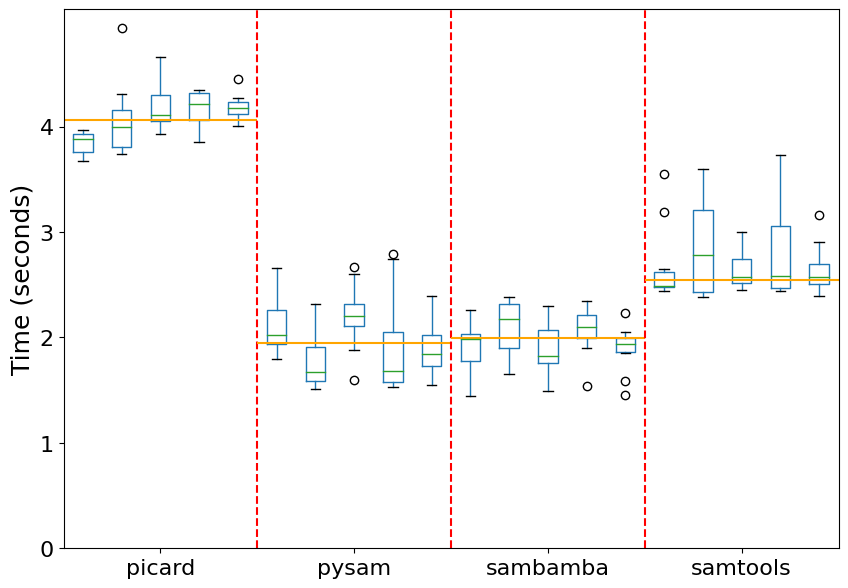

In [29]:
from bioconvert.core.benchmark import plot_multi_benchmark_max

PATH="inputs/json_bam2sam_samtools_v1.7_local/"

benchmark_num = 5

concatenate_json(f"{PATH}/bam2sam_*.json", 
                 output=f"{PATH}/results.json")

_ = plot_multi_benchmark_max(f"{PATH}/bam2sam.json", f"{PATH}/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(5), range(5), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

savefig("images/multi_benchmark_bam2sam_samtools1_7.png", dpi=200)
savefig("images/multi_benchmark_bam2sam_samtools1_7.pdf", dpi=200)

## bam2sam with samtools v1.16 local run


- samtools 1.16 (bioconda) -t4
- sambamba 0.8 (bioconda)  -t4
- pysam 0.20 (bioconda independent of samtools)
- picard 2.26.6 (bioconda)

Here, samtools version was updated and shows a dramatic decrease of computationnal time

- By comparing the picard method with the best one (samtools), we check H0: True with corrected P-value: 1.8021483432166347e-89
- By comparing the pysam method with the best one (samtools), we check H0: True with corrected P-value: 5.5297979013832095e-43
- By comparing the sambamba method with the best one (samtools), we check H0: True with corrected P-value: 2.604810900164652e-42


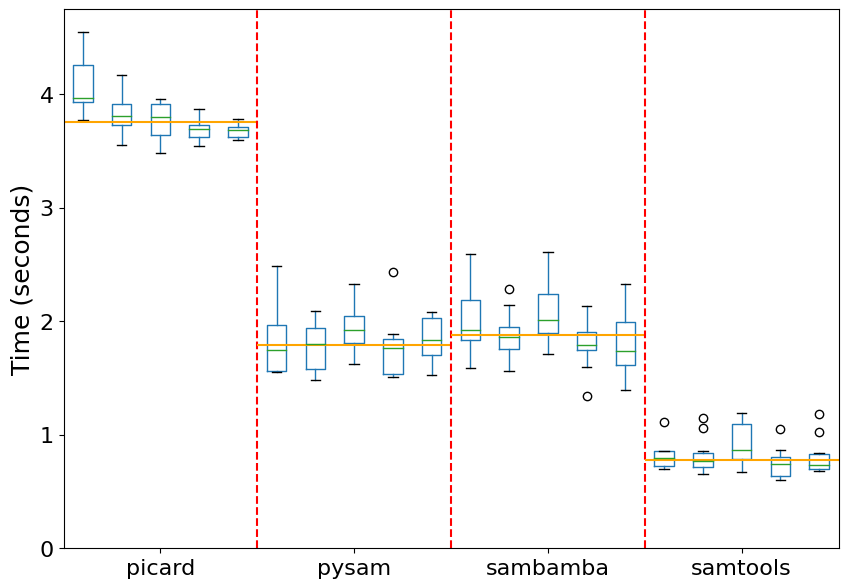

In [21]:
from bioconvert.core.benchmark import plot_multi_benchmark_max

PATH="inputs/json_bam2sam_samtools_v1.16.1_local/"

concatenate_json(f"{PATH}/bam2sam_*.json", 
                 output=f"{PATH}/bam2sam.json")

_ = plot_multi_benchmark_max(f"{PATH}/bam2sam.json", f"{PATH}/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(5), range(5), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

savefig("images/multi_benchmark_bam2sam_samtools1_1.16.png", dpi=200)
savefig("images/multi_benchmark_bam2sam_samtools1_1.16.pdf", dpi=200)

## bam2sam with samtools v1.16 cluster run

- samtools 1.16 (bioconda)
- sambamba 1.0 (bioconda)
- pysam 0.20 (bioconda)
- picard 2.27.5 (bioconda)

- By comparing the picard method with the best one (samtools), we check H0: True with corrected P-value: 1.59959146903442e-94
- By comparing the pysam method with the best one (samtools), we check H0: True with corrected P-value: 2.6792581865654445e-114
- By comparing the sambamba method with the best one (samtools), we check H0: True with corrected P-value: 2.875323052431065e-163


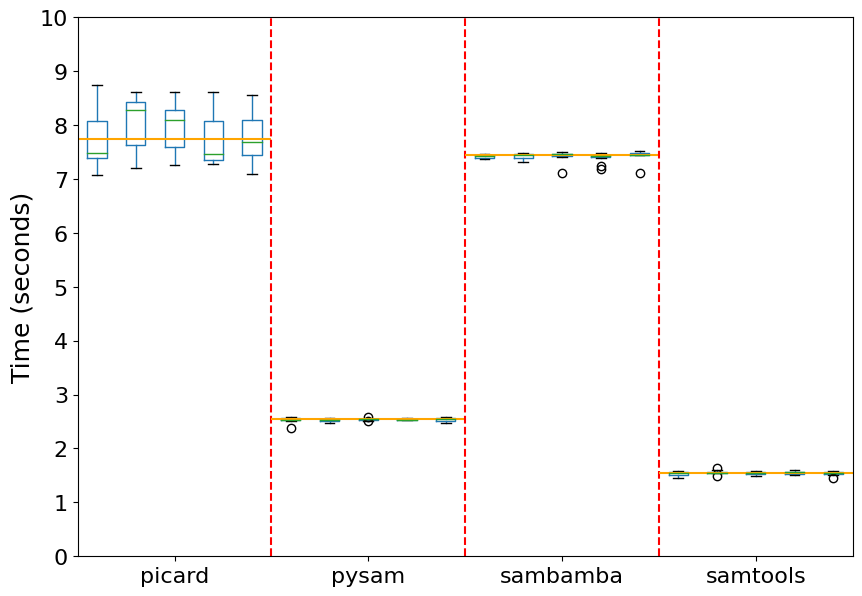

In [22]:
from bioconvert.core.benchmark import plot_multi_benchmark_max
PATH="inputs/json_bam2sam_samtools_v1.16.1_cluster/"

concatenate_json(f"{PATH}/bam2sam_*.json", 
                 output=f"{PATH}/bam2sam.json")
clf()
_ = plot_multi_benchmark_max(f"{PATH}/bam2sam.json", f"{PATH}/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(11), range(11), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

savefig("images/multi_benchmark_bam2sam_samtools_cluster_v1.16.png", dpi=200)
savefig("images/multi_benchmark_bam2sam_samtools_cluster_v1.16.pdf", dpi=200)

## bam2sam with samtools v1.6 cluster run


- samtools 1.6 (bioconda)
- sambamba 1.0 (bioconda)
- pysam 0.20 (bioconda)
- picard 2.27.5 (bioconda)

- By comparing the picard method with the best one (pysam), we check H0: True with corrected P-value: 1.454730018483212e-79
- By comparing the sambamba method with the best one (pysam), we check H0: True with corrected P-value: 1.1845385336207506e-142
- By comparing the samtools method with the best one (pysam), we check H0: True with corrected P-value: 3.3060460222042653e-138


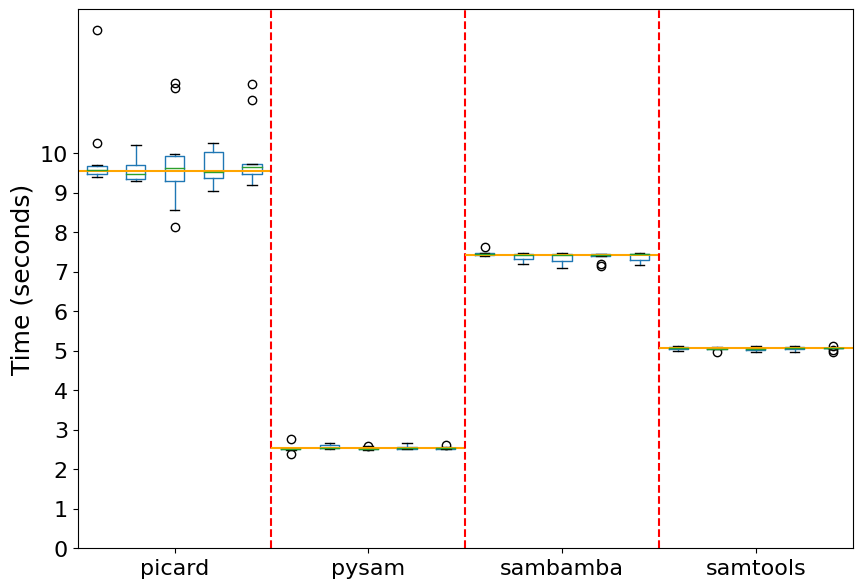

In [23]:
from bioconvert.core.benchmark import plot_multi_benchmark_max
PATH="inputs/json_bam2sam_samtools_v1.6_cluster/"

concatenate_json(f"{PATH}/bam2sam_*.json", 
                 output=f"{PATH}/bam2sam.json")
clf()
_ = plot_multi_benchmark_max(f"{PATH}/bam2sam.json", f"{PATH}/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(11), range(11), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

savefig("images/multi_benchmark_bam2sam_samtools_cluster_v1.6.png", dpi=200)
savefig("images/multi_benchmark_bam2sam_samtools_cluster_v1.6.pdf", dpi=200)

In [ ]:
## fastqtofasta local run 

- awk 5.0
mappy
mawk
perl
readfq
sed
seqkit
seqtk



- By comparing the awk method with the best one (mawk), we check H0: True with corrected P-value: 5.201895604966407e-21
- By comparing the bioconvert method with the best one (mawk), we check H0: True with corrected P-value: 0.01494646009381224
- By comparing the mappy method with the best one (mawk), we check H0: True with corrected P-value: 2.9747978030587306e-23
- By comparing the perl method with the best one (mawk), we check H0: True with corrected P-value: 1.590910487520562e-07
- By comparing the readfq method with the best one (mawk), we check H0: True with corrected P-value: 6.909705102676838e-50
- By comparing the sed method with the best one (mawk), we check H0: False with corrected P-value: 0.6012311961026576
- By comparing the seqkit method with the best one (mawk), we check H0: True with corrected P-value: 2.2872693876774243e-31
- By comparing the seqtk method with the best one (mawk), we check H0: True with corrected P-value: 1.49733620903888e-10


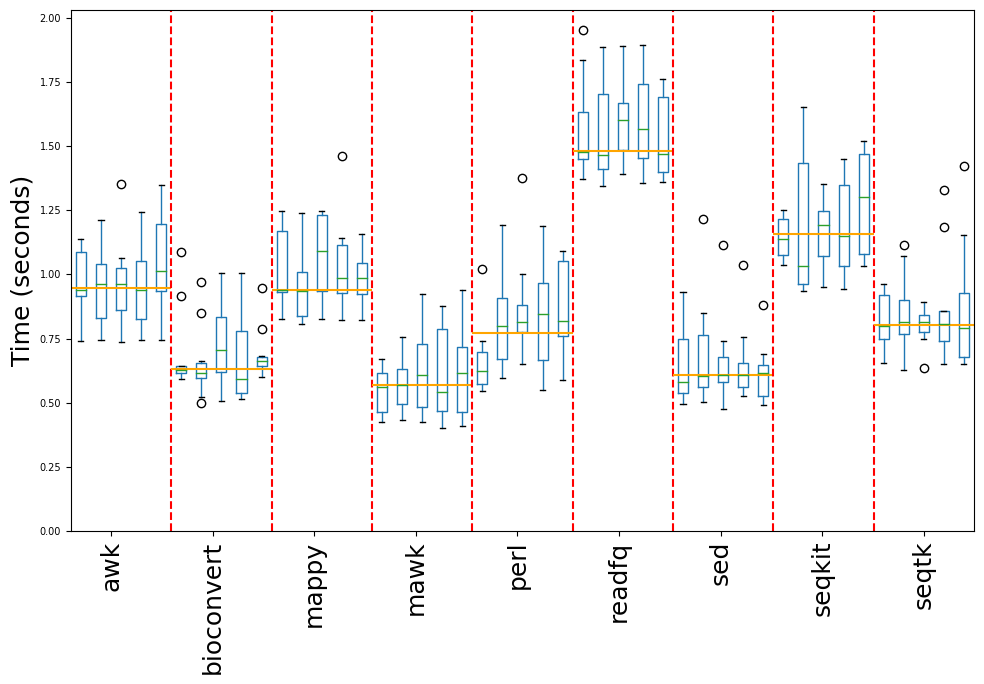

In [28]:
from bioconvert.core.benchmark import plot_multi_benchmark_max

PATH="inputs/json_fastq2fasta/"


concatenate_json(f"{PATH}/test_fastq2fasta_*.json", 
                 output=f"{PATH}/results.json")

_ = plot_multi_benchmark_max(f"{PATH}/results.json", f"{PATH}/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
#_ = yticks(range(5), range(5), fontsize=16)
#_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

methods = ['awk', 'bioconvert', 'mappy', 'mawk', 'perl', 'readfq', 'sed', 'seqkit', 'seqtk' ]
xticks(linspace(2.5,43,9), methods, rotation=90, fontsize=18)
tight_layout()
savefig("images/multi_benchmark_fastq2fasta.png", dpi=200)
savefig("images/multi_benchmark_fastq2fasta.pdf", dpi=200)